In [10]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
sys.path.append("./../..")

# standard lib
import shutil
from pathlib import Path

# external imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import scipy as sp
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

# local imports
from datasets import AffNIST
from effcn.layers import Squash
from effcn.functions import margin_loss, max_norm_masking
from misc.utils import count_parameters
from misc.plot_utils import plot_couplings, plot_capsules, plot_mat, plot_mat2
from misc.metrics import *

In [12]:
if torch.cuda.is_available():  
    dev = "cuda" 
else:  
    dev = "cpu"  
device = torch.device(dev)

# Data

In [13]:
transform_train = T.Compose([
    T.RandomAffine(degrees=(-8, 8),
                   shear=(-15, 15),
                   scale=(0.9, 1.1)
                  ),
    T.Normalize((0.0641,), (0.2257))
])
transform_valid = T.Normalize((0.0641,), (0.2257))

p_data = '/mnt/data/datasets/affnist'

ds_mnist_train = AffNIST(p_root=p_data, split="mnist_train", download=True, transform=transform_train, target_transform=None)
ds_mnist_valid = AffNIST(p_root=p_data, split="mnist_valid", download=True, transform=transform_valid, target_transform=None)
ds_affnist_valid = AffNIST(p_root=p_data, split="affnist_valid", download=True, transform=transform_valid, target_transform=None)

In [14]:
bs = 512
dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, 
    batch_size=bs, 
    shuffle=True,
    pin_memory=True,
    num_workers=4)
dl_mnist_valid= torch.utils.data.DataLoader(
    ds_mnist_valid, 
    batch_size=bs, 
    shuffle=True, 
    pin_memory=True,
    num_workers=4)
dl_affnist_valid= torch.utils.data.DataLoader(
    ds_affnist_valid, 
    batch_size=bs, 
    shuffle=True, 
    pin_memory=True,
    num_workers=4)

In [15]:
x, _ = next(iter(dl_mnist_train))
x_vis_train = x[:32]

x, _ = next(iter(dl_mnist_valid))
x_vis_mnist_valid = x[:32]

x, _ = next(iter(dl_affnist_valid))
x_vis_affnist_valid = x[:32]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


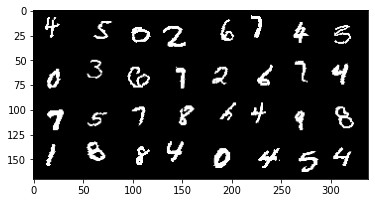

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


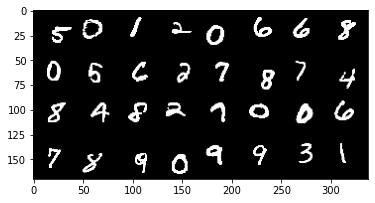

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


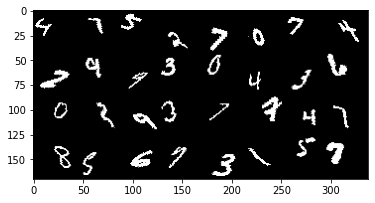

In [16]:
plt.imshow(torchvision.utils.make_grid(x_vis_train).permute(1,2,0))
plt.show()
#
plt.imshow(torchvision.utils.make_grid(x_vis_mnist_valid).permute(1,2,0))
plt.show()
#
plt.imshow(torchvision.utils.make_grid(x_vis_affnist_valid).permute(1,2,0))
plt.show()

# Models

### Backbone

In [17]:
class CustomBB(nn.Module):
    """
        Custom backbone
    """
    def __init__(self, ch_in=3, n_classes=10):
        super().__init__()
        self.ch_in = ch_in
        self.n_classes=n_classes
    
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=ch_in, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=9, groups=256, stride=1, padding="valid"),
        )
        self.fc = nn.Linear(256 , n_classes)
    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

In [18]:
# Check if it works
model = CustomBB(ch_in=1)
y = model(torch.rand(128, 1, 40, 40))
print(count_parameters(model))
print(y.shape)

320778
torch.Size([128, 10])


In [19]:
count_parameters(model)

320778

In [20]:
class FCCaps(nn.Module):
    """
        Attributes
        ----------
        n_l ... number of lower layer capsules
        d_l ... dimension of lower layer capsules
        n_h ... number of higher layer capsules
        d_h ... dimension of higher layer capsules

        W   (n_l, n_h, d_l, d_h) ... weight tensor
        B   (n_l, n_h)           ... bias tensor
    """

    def __init__(self, n_l, n_h, d_l, d_h):
        super().__init__()
        self.n_l = n_l
        self.d_l = d_l
        self.n_h = n_h
        self.d_h = d_h
        
        
        self.W = torch.nn.Parameter(torch.rand(
            n_l, n_h, d_l, d_h), requires_grad=True)
        self.B = torch.nn.Parameter(torch.rand(n_l, n_h), requires_grad=True)
        self.squash = Squash(eps=1e-20)

        # init custom weights
        # i'm relly unsure about this initialization scheme
        # i don't think it makes sense in our case, but the paper says so ...
        torch.nn.init.kaiming_normal_(
            self.W, a=0, mode='fan_in', nonlinearity='leaky_relu')
        torch.nn.init.kaiming_normal_(
            self.B, a=0, mode="fan_in", nonlinearity="leaky_relu")

        self.attention_scaling = np.sqrt(self.d_l)

    def forward(self, U_l):
        """
        einsum convenventions:
          n_l = i | h
          d_l = j
          n_h = k
          d_h = l

        Data tensors:
            IN:  U_l ... lower layer capsules
            OUT: U_h ... higher layer capsules
            DIMS:
                U_l (n_l, d_l)
                U_h (n_h, d_h)
                W   (n_l, n_h, d_l, d_h)
                B   (n_l, n_h)
                A   (n_l, n_l, n_h)
                C   (n_l, n_h)
        """
        U_hat = torch.einsum('...ij,ikjl->...ikl', U_l, self.W)
        A = torch.einsum("...ikl, ...hkl -> ...hik", U_hat, U_hat)
        
        # I removed the scaling, to enforce stronger couplings
        #A = A / self.attention_scaling)
        
        
        A_sum = torch.einsum("...hij->...hj", A)
        C = torch.softmax(A_sum, dim=-1)
        
        # I removed the Bias term
        #CB = C + B
        
        U_h = torch.einsum('...ikl,...ik->...kl', U_hat, C)
        return self.squash(U_h)

    def forward_debug(self, U_l):
        """
            Same as forward() but returns more stuff to analyze routing
        """
        U_hat = torch.einsum('...ij,ikjl->...ikl', U_l, self.W)
        A = torch.einsum("...ikl, ...hkl -> ...hik", U_hat, U_hat)
        
        # I removed the scaling, to create stronger couplings
        #A = A / self.attention_scaling)
        
        
        A_sum = torch.einsum("...hij->...hj", A)
        C = torch.softmax(A_sum, dim=-1)
        
        # I removed the Bias term
        #CB = C + B
        
        U_h = torch.einsum('...ikl,...ik->...kl', U_hat, C)
        return self.squash(U_h), C

class DeepCapsNet(nn.Module):
    """
        A Deeper CN that allows
    """
    def __init__(self, ns, ds):
        super().__init__()
        self.ns = ns
        self.ds = ds
        
        self.backbone = CustomBB(ch_in=1)
        self.backbone.fc = nn.Identity()
        
        self.squash = Squash(eps=1e-20)
        layers = []
        for idx in range(1, len(ns), 1):
            n_l = ns[idx - 1]
            n_h = ns[idx]
            d_l = ds[idx - 1]
            d_h = ds[idx]
            layers.append(FCCaps(n_l, n_h, d_l, d_h) )
        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        x = self.backbone(x)
        
        # primecaps
        x = self.squash(x.view(-1, self.ns[0], self.ds[0]))
        
        for layer in self.layers:
            x = layer(x)
        return x

    def forward_debug(self, x):
        x = self.backbone(x)
        
        # primecaps
        x = self.squash(x.view(-1, self.ns[0], self.ds[0]))
        
        us = [torch.clone(x)]
        cc = []
        # fccaps
        for layer in self.layers:
            x, c = layer.forward_debug(x)
            cc.append(c.detach())
            us.append(torch.clone(x).detach())
        return x, cc, us

In [21]:
ns = [32, 10, 10, 10, 10]
ds = [8, 16, 16, 16, 16]

#ns = [32, 10, 10, 10, 10]  # geht
#ds = [8, 16, 16, 16, 16]

ns = [32, 32, 32, 10]
ds = [8, 8, 8, 16]

model = DeepCapsNet(ns=ns, ds=ds)
#
print("tot Model ", count_parameters(model))
print("Backbone  ", count_parameters(model.backbone))
#
model = model.to(device)
model

tot Model  492608
Backbone   318208


DeepCapsNet(
  (backbone): CustomBB(
    (convs): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(256, 256, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=256)
    )
    (fc): Identity()
  )
  (squash): Squash()
  (layers): Sequential(
    (0): FCCaps(
      (squash): Squash()
    )
    (1): FCCaps(
      (squash): Squash()
    )
    (2): FCCaps(
      (squash): Squash()
    )
  )
)

In [22]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [23]:
num_epochs = 11
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_mnist_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        u_h = model.forward(x)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=10)
        loss = margin_loss(u_h, y_one_hot)

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    lr_scheduler.step()
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_mnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   mnist acc_valid: {:.3f}".format(total_correct / total))

    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_affnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   affnist acc_valid: {:.3f}".format(total_correct / total))

Train [  0/ 11]:██████████| 118/118 [00:07<00:00, 15.97it/s, loss=0.523, acc=0.104] 


   mnist acc_valid: 0.113
   affnist acc_valid: 0.113


Train [  1/ 11]:██████████| 118/118 [00:07<00:00, 16.00it/s, loss=0.443, acc=0.208]
Train [  2/ 11]:██████████| 118/118 [00:07<00:00, 15.77it/s, loss=0.279, acc=0.656]
Train [  3/ 11]:██████████| 118/118 [00:07<00:00, 15.73it/s, loss=0.114, acc=0.854]
Train [  4/ 11]:██████████| 118/118 [00:07<00:00, 15.57it/s, loss=0.0877, acc=0.906]
Train [  5/ 11]:██████████| 118/118 [00:07<00:00, 15.49it/s, loss=0.0324, acc=0.948]


   mnist acc_valid: 0.957
   affnist acc_valid: 0.672


Train [  6/ 11]:██████████| 118/118 [00:07<00:00, 15.38it/s, loss=0.0788, acc=0.896]
Train [  7/ 11]:██████████| 118/118 [00:07<00:00, 15.29it/s, loss=0.0569, acc=0.927]
Train [  8/ 11]:██████████| 118/118 [00:07<00:00, 15.21it/s, loss=0.0269, acc=0.979]
Train [  9/ 11]:██████████| 118/118 [00:07<00:00, 15.13it/s, loss=0.0423, acc=0.948]
Train [ 10/ 11]:██████████| 118/118 [00:07<00:00, 15.16it/s, loss=0.0407, acc=0.938]


   mnist acc_valid: 0.971
   affnist acc_valid: 0.721


# Visualize and Analyze

### Show parse tree and activations for individual samples

In [24]:
x, y = next(iter(dl_affnist_valid))

model.eval()
with torch.no_grad():
    u_h, CC, US = model.forward_debug(x.to(device))
y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
y_pred = y_pred.detach().cpu().numpy()
#
US = [u.cpu().numpy() for u in US]
CS = [c.cpu().numpy() for c in CC]
#
Y_true = y.cpu().numpy()
Y_pred = y_pred

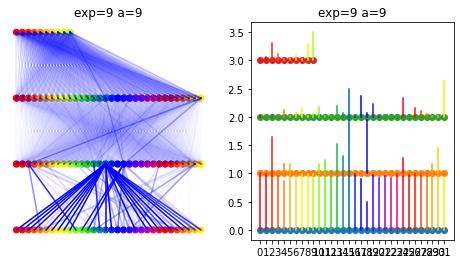

In [25]:
vis_class = 9
vis_max = 32
for idx in range(vis_max):
    if vis_class is not None and Y_true[idx] != vis_class:
        continue
    cs = [c[idx] for c in CS]
    us = [u[idx] for u in US]
    u_norms = [np.linalg.norm(u, axis=1) for u in us]
    
    # plot stuff
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    title = "exp={} a={}".format(y[idx], y_pred[idx])
    #
    plot_couplings(cs, title=title, ax=axes[0], show=False)
    plot_capsules(u_norms, title=title , ax=axes[1], show=False)
    plt.show()
    break

# Statistics For Further Evaluation and Visualization

In [26]:
model.eval()

YY = []
CC = [[] for _ in range(len(ns) - 1)]
US = [[] for _ in range(len(ns))]


# use whole dataset
for x,y_true in dl_affnist_valid:
    x = x.to(device)
        
    with torch.no_grad():
        _, cc, us = model.forward_debug(x.to(device))
        for idx in range(len(cc)):
            CC[idx].append(cc[idx].detach().cpu().numpy())
        for idx in range(len(us)):
            US[idx].append(us[idx].detach().cpu().numpy())
        YY.append(y_true.numpy())
        
# Dataset Labels
YY = np.concatenate(YY)

# Dataset Coupling Coefficient Matrices
CC = [np.concatenate(c) for c in CC]

# Dataset Capsules
US = [np.concatenate(u) for u in US]

### Mean parse tree and mean activation for dataset

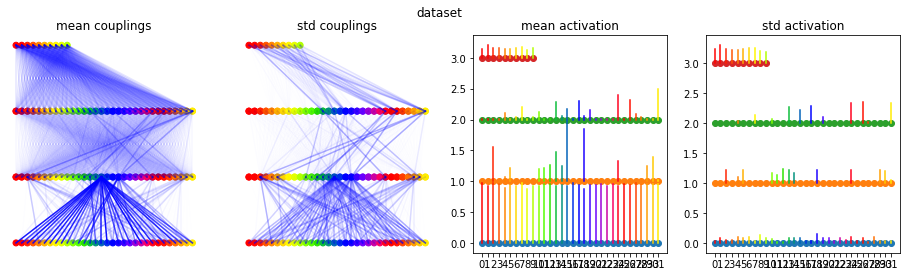

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
# Mean parse tree
cc_mean = [np.mean(c, axis=0) for c in CC]
cc_std = [np.std(c, axis=0) for c in CC]
plot_couplings(cc_mean, ax=axes[0], show=False, title="mean couplings")
plot_couplings(cc_std, ax=axes[1], show=False, title="std couplings")
    
# mean and std capsule activation
us_mean = [np.linalg.norm(u, axis=-1).mean(axis=0) for u in US]
us_std = [np.linalg.norm(u, axis=-1).std(axis=0) for u in US]
plot_capsules(us_mean, scale_factor=1, ax=axes[2], show=False, title="mean activation")
plot_capsules(us_std, scale_factor=1, ax=axes[3], show=False, title="std activation")
plt.suptitle("dataset")
plt.show()

### Parse tree from normalized Couplings

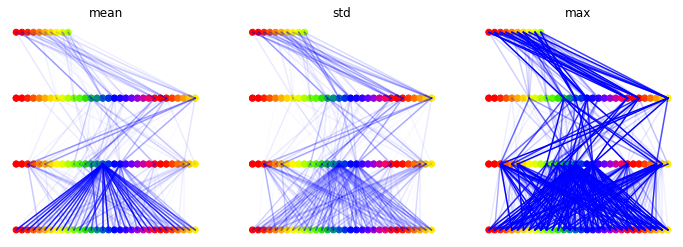

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(4 * len(CC), 4))

CNS = [normalize_couplings(C) for C in CC]

CNS_MAN = [ma_couplings(C, pr) for C, pr in CNS]
CNS_MAX = [C.max(axis=0) for C, pr in CNS]
CNS_STD = [stda_couplings(C, pr) for C, pr in CNS]

plot_couplings(CNS_MAN, ax=axes[0], show=False, title="mean")
plot_couplings(CNS_STD, ax=axes[1], show=False, title="std")
plot_couplings(CNS_MAX, ax=axes[2], show=False, title="max")
plt.show()

In [69]:
len(CNS)

len(CNS[1][0])

len(CNS[2][1])

32

### Classwise mean parse tree and mean activation

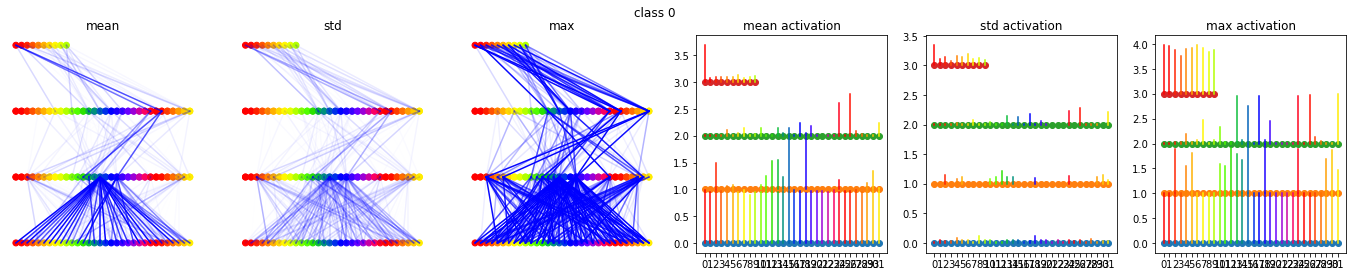

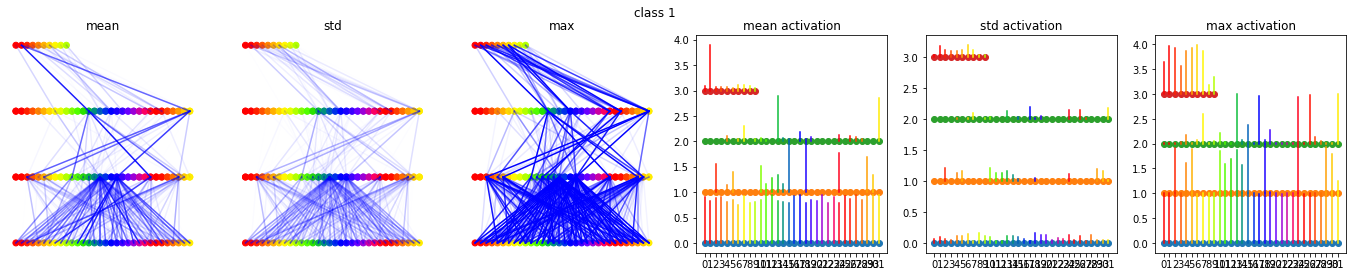

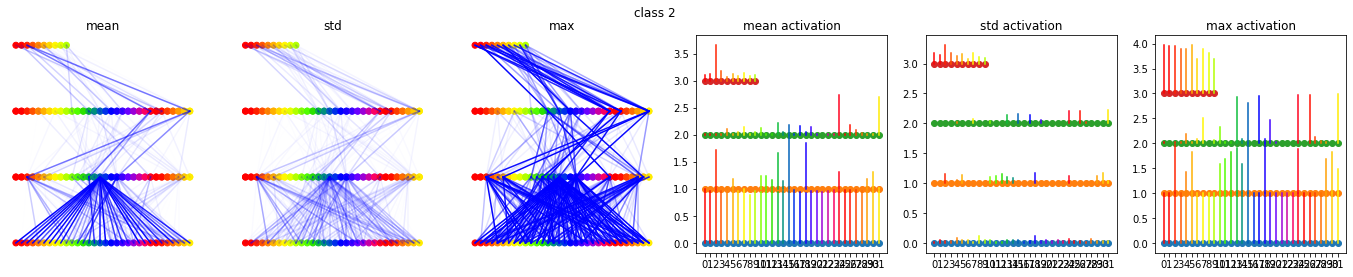

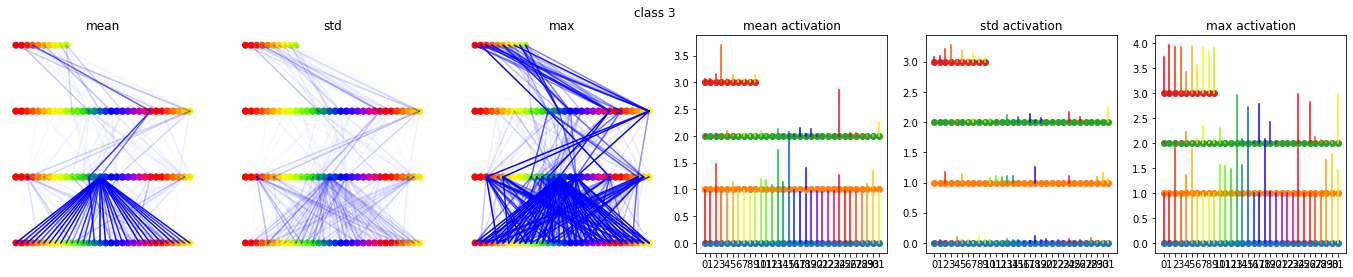

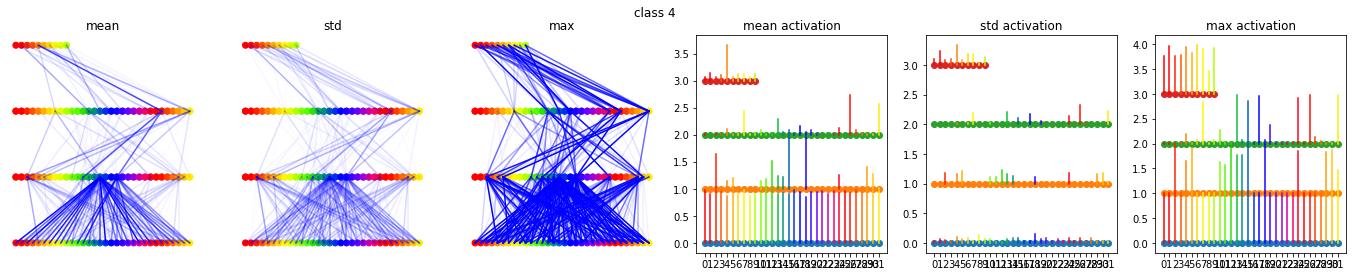

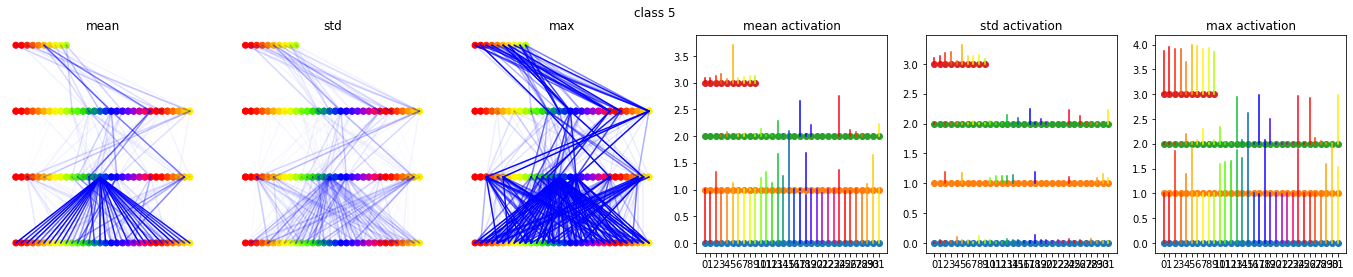

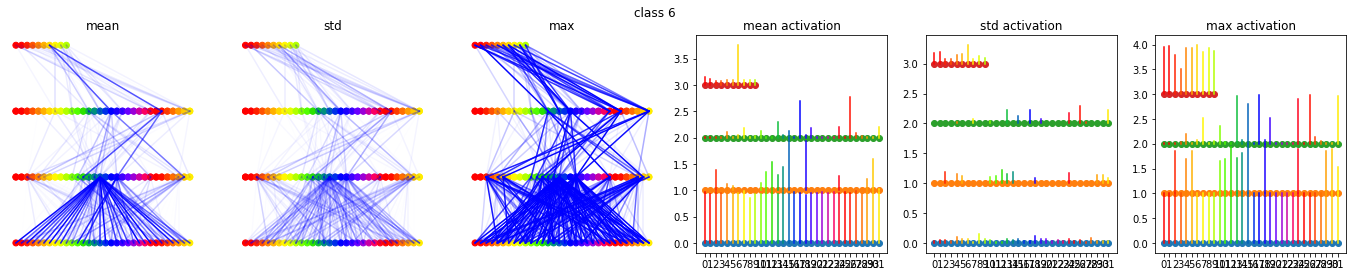

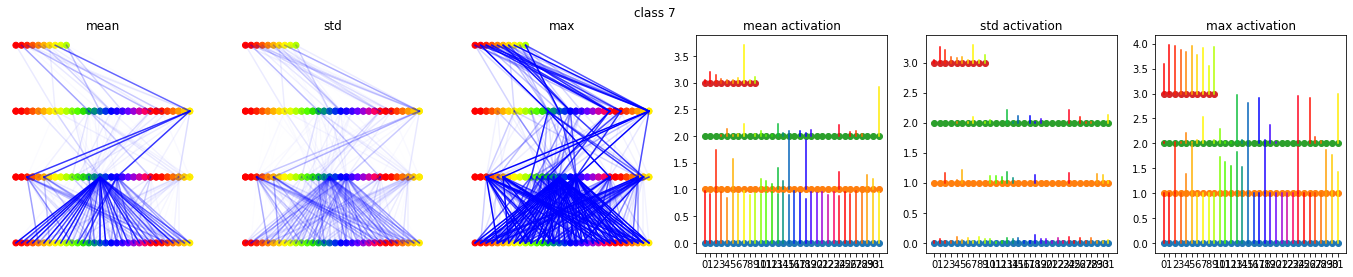

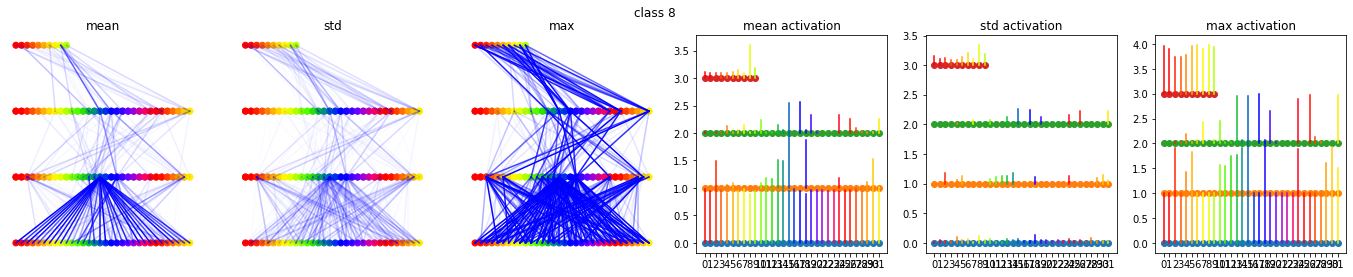

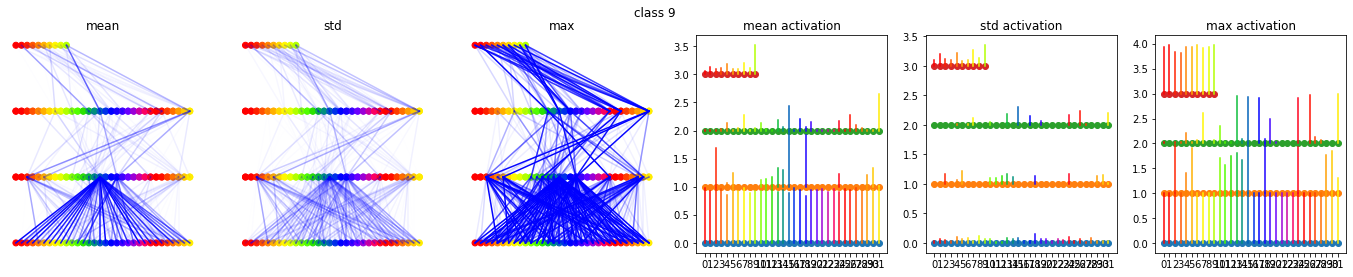

In [29]:
# mean and variance activation
for cls in range(10):
    idcs = np.where(YY == cls)[0]
    
    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    
    cc = [C[idcs] for C in CC]
    CNS = [normalize_couplings(C, eps_rate=0.5) for C in cc]
    
    CNS_MAN = [ma_couplings(C, pr) for C, pr in CNS]
    CNS_MAX = [C.max(axis=0) for C, pr in CNS]
    CNS_STD = [stda_couplings(C, pr) for C, pr in CNS]

    plot_couplings(CNS_MAN, ax=axes[0], show=False, title="mean")
    plot_couplings(CNS_STD, ax=axes[1], show=False, title="std")
    plot_couplings(CNS_MAX, ax=axes[2], show=False, title="max")
    
    # mean and std capsule activation
    us = [u[idcs] for u in US]
    us_mean = [np.linalg.norm(u, axis=-1).mean(axis=0) for u in us]
    us_std = [np.linalg.norm(u, axis=-1).std(axis=0) for u in us]
    us_max = [np.linalg.norm(u, axis=-1).max(axis=0) for u in us]
    
    plot_capsules(us_mean, scale_factor=1, ax=axes[3], show=False, title="mean activation")
    plot_capsules(us_std, scale_factor=1, ax=axes[4], show=False, title="std activation")
    plot_capsules(us_max, scale_factor=1, ax=axes[5], show=False, title="max activation")
    plt.suptitle("class {}".format(cls))
    plt.show()

# Coupling Death vs Alive

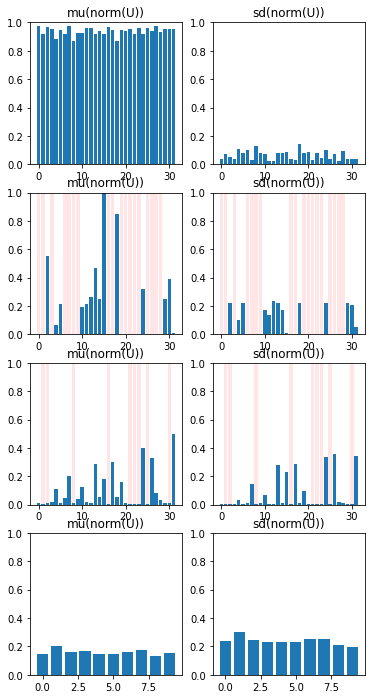

In [30]:
c_th_mu = 1e-2
c_th_sd = 1e-2

fig, axes = plt.subplots(len(US), 2, figsize=(6, 3 * len(US)))
#
US_alive = []
for idx in range(len(US)):
    U = US[idx]
    U_norm = np.linalg.norm(U, axis=2)
    U_norm_mu = U_norm.mean(axis=0)
    U_norm_sd = U_norm.std(axis=0)
    #
    U_dead = (U_norm_sd < 1e-2) * (U_norm_mu < 1e-2)
    #
    xx = range(len(U_norm_mu))
    axes[idx][0].set_title("mu(norm(U))")
    axes[idx][0].bar(xx, U_dead, color="red",alpha=0.1)
    axes[idx][0].bar(xx, U_norm_mu)
    axes[idx][0].set_ylim(0, 1)
    axes[idx][1].set_title("sd(norm(U))")
    axes[idx][1].bar(xx, U_norm_sd)
    axes[idx][1].bar(xx, U_dead, color="red",alpha=0.1)
    axes[idx][1].set_ylim(0, 1)
    U_alive = 1 - U_dead
    US_alive.append(U_alive)
plt.show()

# Metrics

### Vibrance

In [31]:
for U in US:
    pr = rate_dead_capsules_norm(U)
    print("#Permanently Dead: {:.3f}".format(pr.mean()))

#Permanently Dead: 0.000
#Permanently Dead: 0.562
#Permanently Dead: 0.281
#Permanently Dead: 0.000


In [32]:
for C in CC:
    pr = rate_inactive_capsules(C)
    print("Rate inactive capsules {:.3f}".format(pr.mean()))

Rate inactive capsules 0.000
Rate inactive capsules 0.696
Rate inactive capsules 0.898


In [33]:
# sanity check
for idx in range(len(CC)):
    C = CC[idx]
    U = US[idx]
    #
    rnd, rac, racnd =  get_vibrance(U, C)
    #
    print("rate alive: {:.3f} rate active {:.3f} rate active of alive {:.3f}".format(
        rnd, rac, racnd))

rate alive: 1.000 rate active 1.000 rate active of alive 1.000
rate alive: 0.438 rate active 0.304 rate active of alive 0.694
rate alive: 0.719 rate active 0.102 rate active of alive 0.141


### Bonding

In [34]:
for idx in range(len(CC)):
    C = CC[idx]
    b = get_bonding(C)
    print_str = "bonding strength: {:.3f}"
    print(print_str.format(b))

bonding strength: 0.809
bonding strength: 0.302
bonding strength: 0.451


### Dynamics

In [35]:
for idx in range(len(CC)):
    C = CC[idx]
    dyc = get_dynamics(C)
    #
    print("dynamics: {:.3f}".format(
          dyc))

dynamics: 0.140
dynamics: 0.088
dynamics: 0.320


### Correlation Capsule Activation and Max Coupling

In [36]:
for idx in range(len(CC)):
    U = US[idx]
    C = CC[idx]
    print("corr: {:.3f}".format(activation_coupling_corr(C, U)))

corr: 0.331
corr: 0.827
corr: 0.914


### metrics for whole dataset

In [37]:
vals = []
for idx in range(len(CC)):
    C = CC[idx]
    U = US[idx]
    #
    rnd, rac, racnd = get_vibrance(U, C)
    b = get_bonding(C)
    dyc = get_dynamics(C)
    cor = activation_coupling_corr(C, U)
    vals.append((idx,
                 rnd, rac, racnd,
                 b, dyc, cor))

In [38]:
cols = ["layer",
        "alive rate", "active rate", "active of alive rate",
        "bonding str.", "dynamics", "cor"]
df = pd.DataFrame(data=vals, columns=cols)
df

layer  alive rate  active rate  active of alive rate  bonding str.  \
0      0        1.00         1.00                  1.00          0.81   
1      1        0.44         0.30                  0.69          0.30   
2      2        0.72         0.10                  0.14          0.45   

   dynamics  cor  
0      0.14 0.33  
1      0.09 0.83  
2      0.32 0.91

### metrics for whole dataset, but classwise

In [39]:

vals = []

#
for cls in range(10):
    idcs = np.where(YY == cls)[0]
    for idx in range(len(CC)):
        C = CC[idx][idcs]
        U = US[idx][idcs]
        #
        rnd, rac, racnd = get_vibrance(U, C)
        b = get_bonding(C)
        dyc = get_dynamics(C)
        cor = activation_coupling_corr(C, U)
        vals.append((cls, idx,
                     rnd, rac, racnd,
                     b, dyc, cor))

In [40]:
cols = ["class", "layer",
        "alive rate", "active rate", "active of alive rate",
        "bonding str.", "dynamics", "cor"]
df = pd.DataFrame(data=vals, columns=cols)
#

In [41]:
for idx in range(len(CC)):
    sdf = df[df["layer"] == idx].drop(columns=["layer"])
    print(sdf)

    class  alive rate  active rate  active of alive rate  bonding str.  \
0       0        1.00         1.00                  1.00          0.85   
3       1        1.00         1.00                  1.00          0.69   
6       2        1.00         1.00                  1.00          0.84   
9       3        1.00         1.00                  1.00          0.87   
12      4        1.00         1.00                  1.00          0.79   
15      5        1.00         1.00                  1.00          0.83   
18      6        1.00         1.00                  1.00          0.80   
21      7        1.00         1.00                  1.00          0.80   
24      8        1.00         1.00                  1.00          0.84   
27      9        1.00         1.00                  1.00          0.81   

    dynamics  cor  
0       0.10 0.20  
3       0.14 0.42  
6       0.10 0.25  
9       0.08 0.28  
12      0.14 0.25  
15      0.09 0.27  
18      0.12 0.22  
21      0.12 0.26  
24   

# Couplings Viszalizations

#### Couplings FROM DEAD Capsules

No dead capsules for layer 0


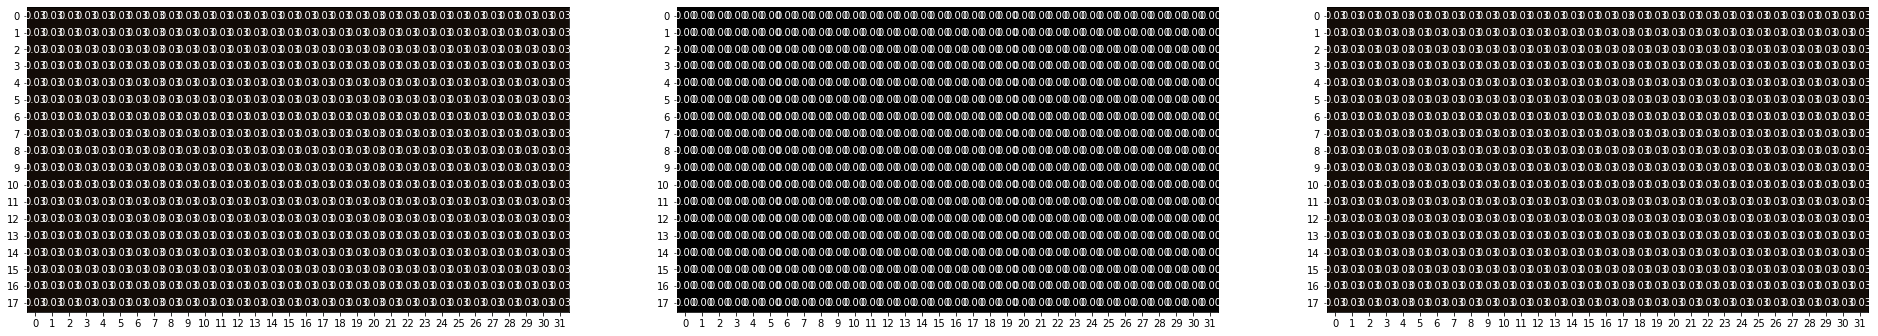

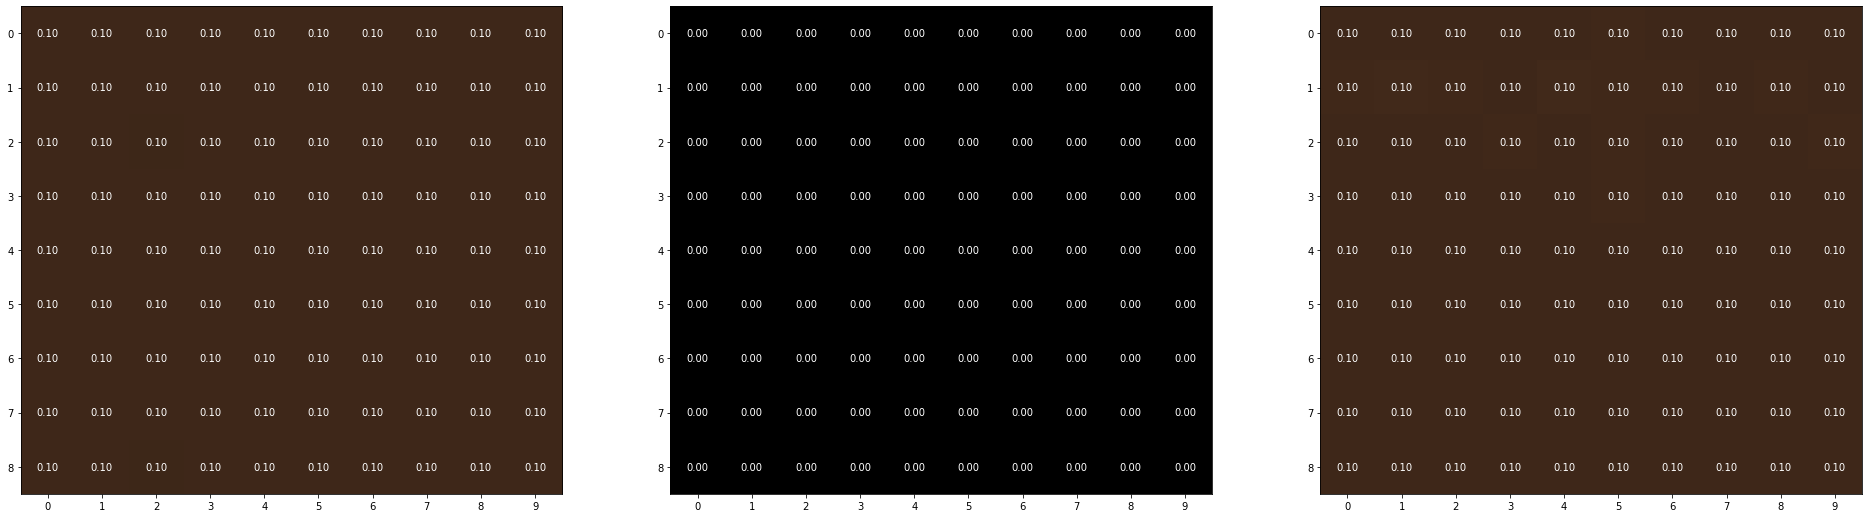

In [42]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    C = C[:,np.where(Ul_alive == False)[0],:]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

#### Couplings FROM Alive Capsules

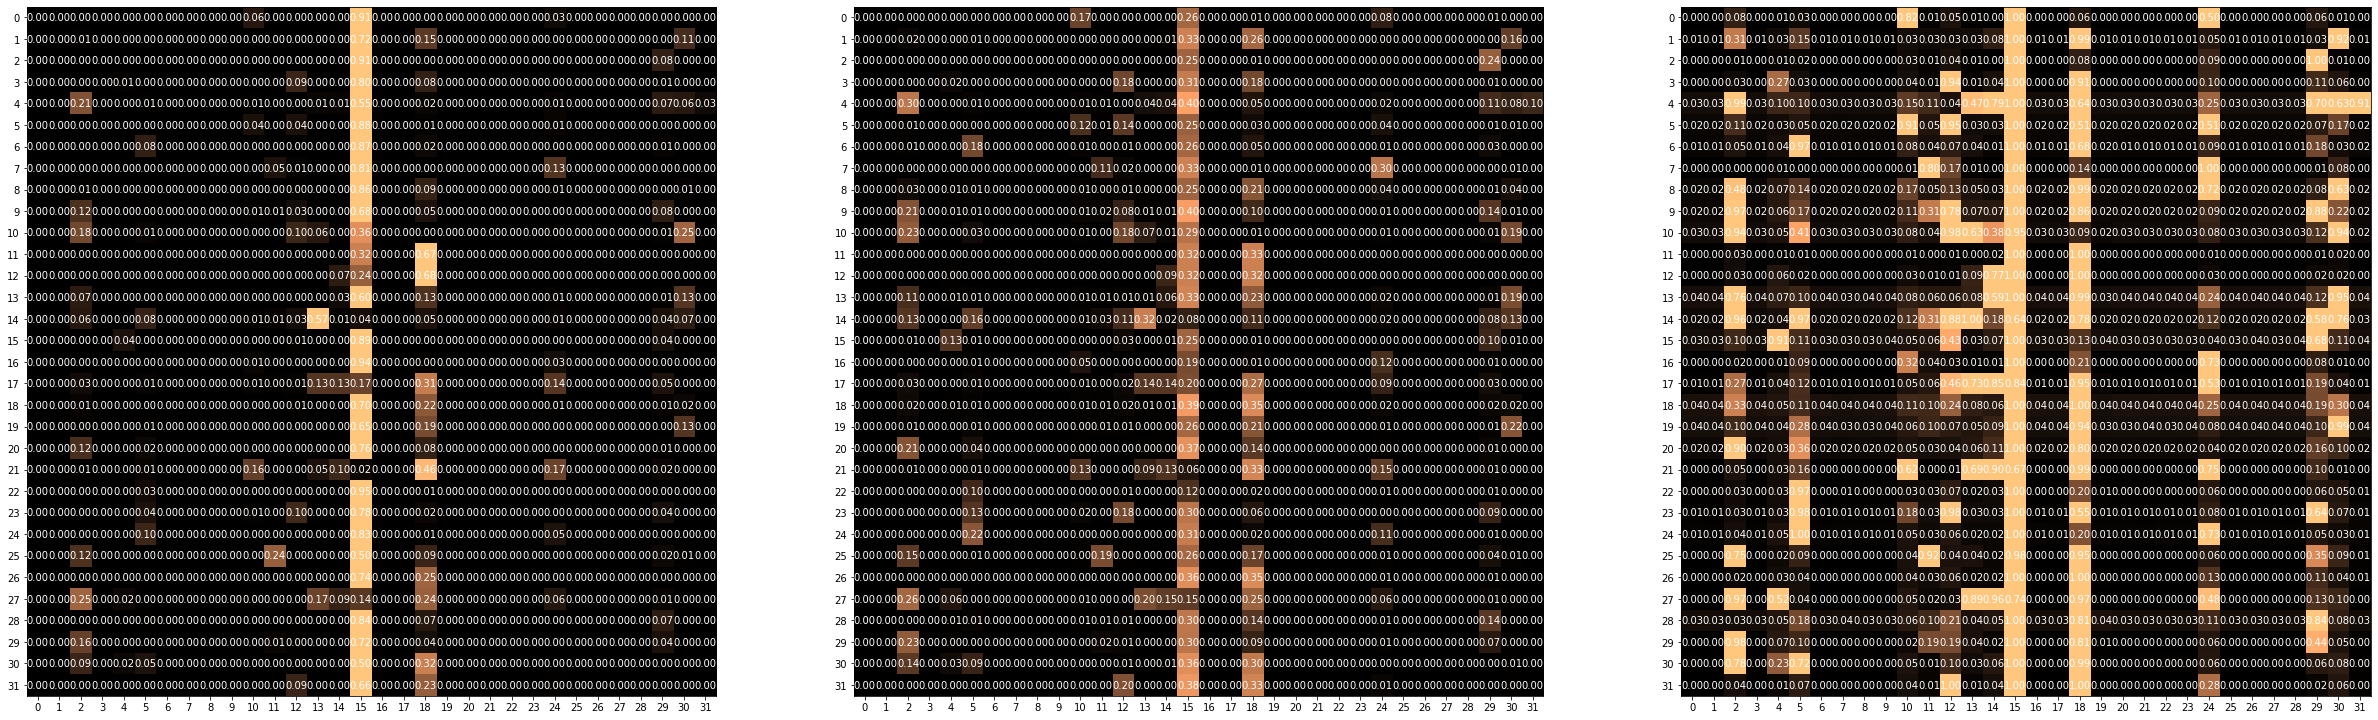

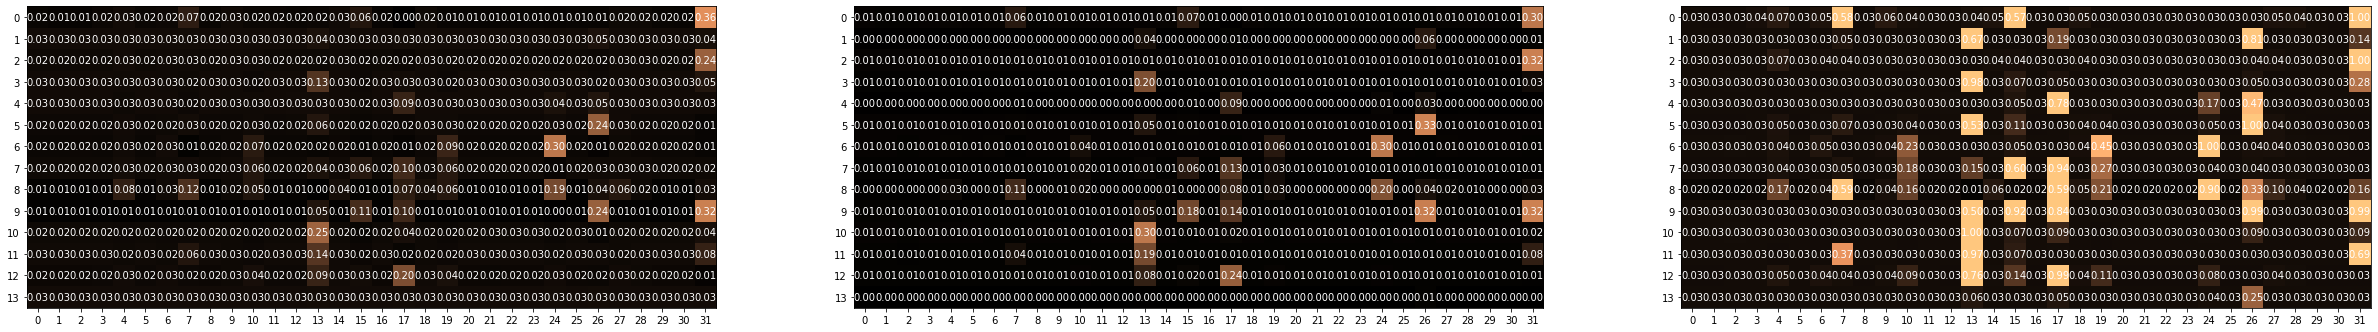

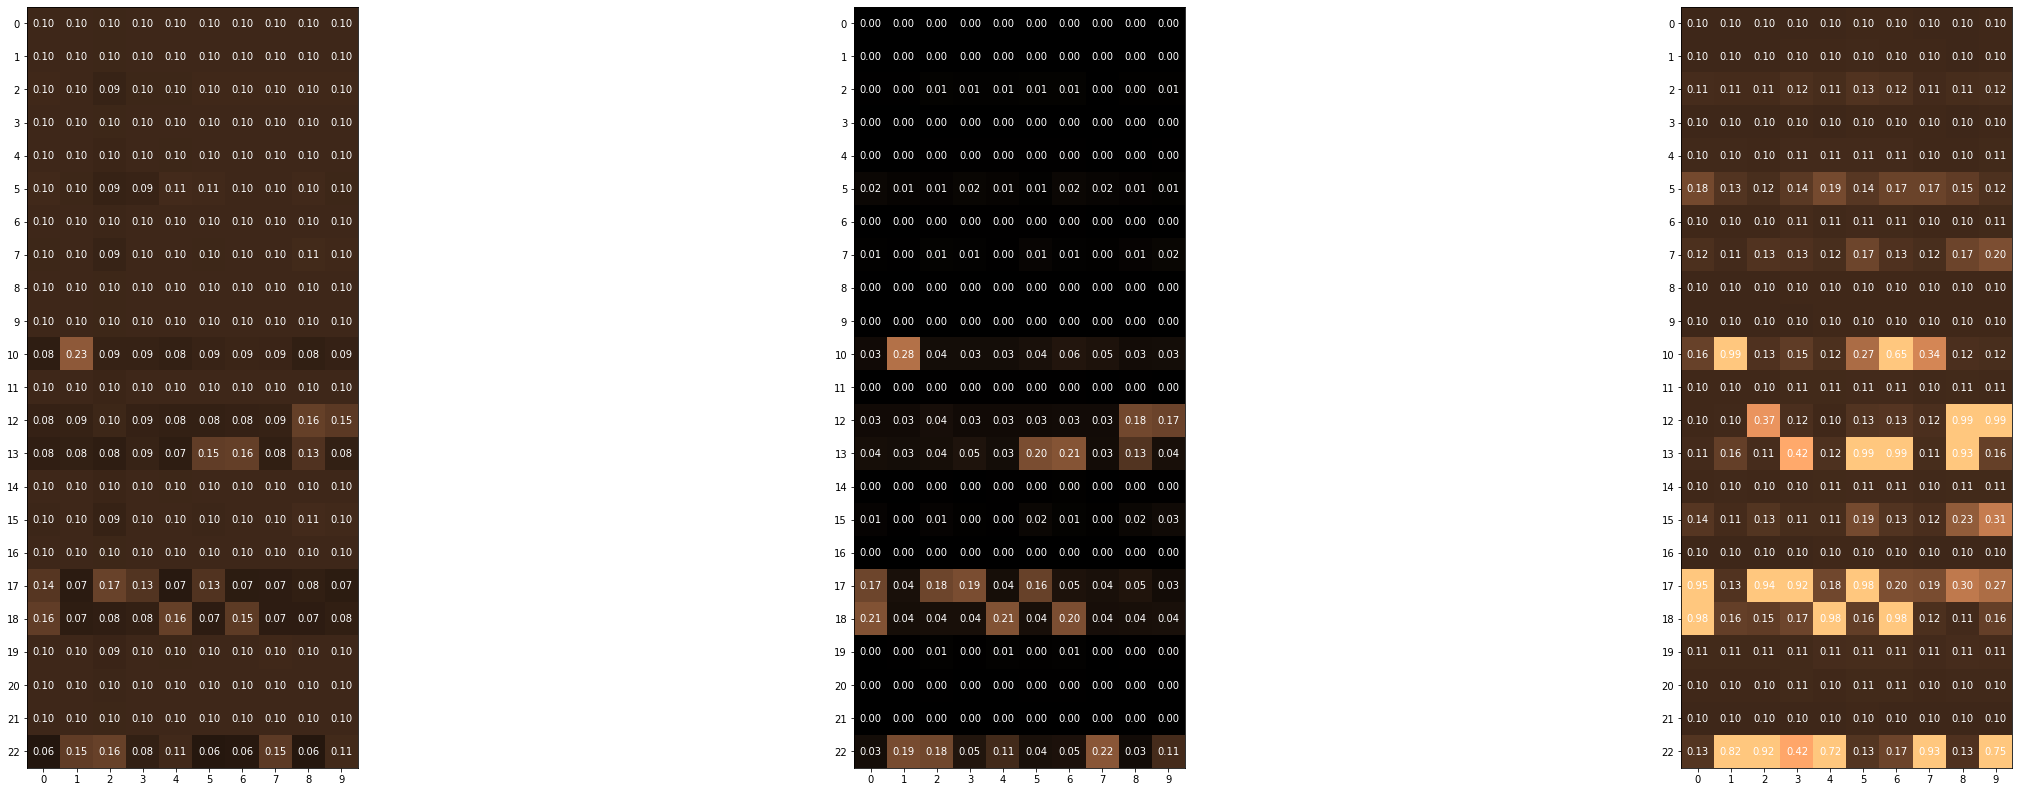

In [43]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    C = C[:,np.where(Ul_alive == True)[0],:]
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(42, 14))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

per sample count max coupling and use max to find out if coupling in general gets lower or just the average as they are loosly connected


### Couplings FROM ALIVE to DEAD

2 No dead capsules for upper layer 3


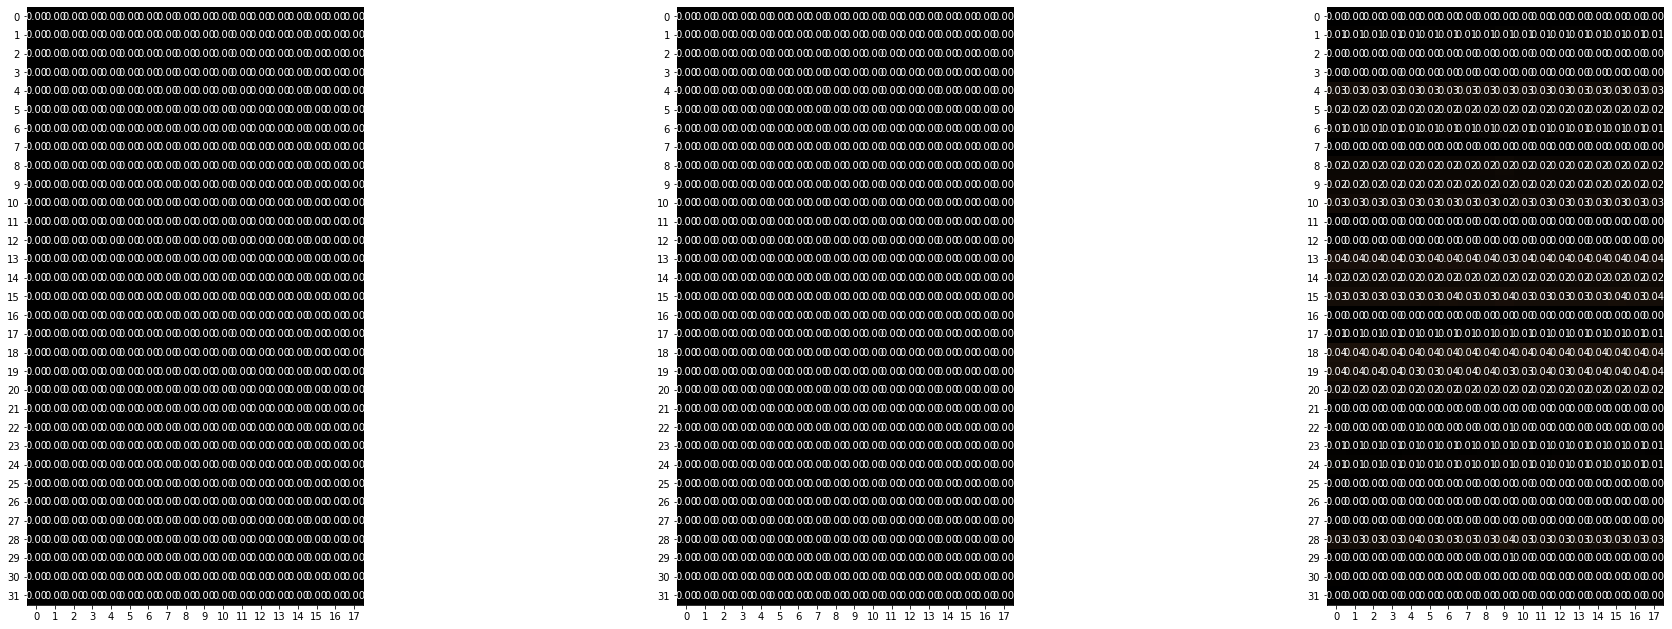

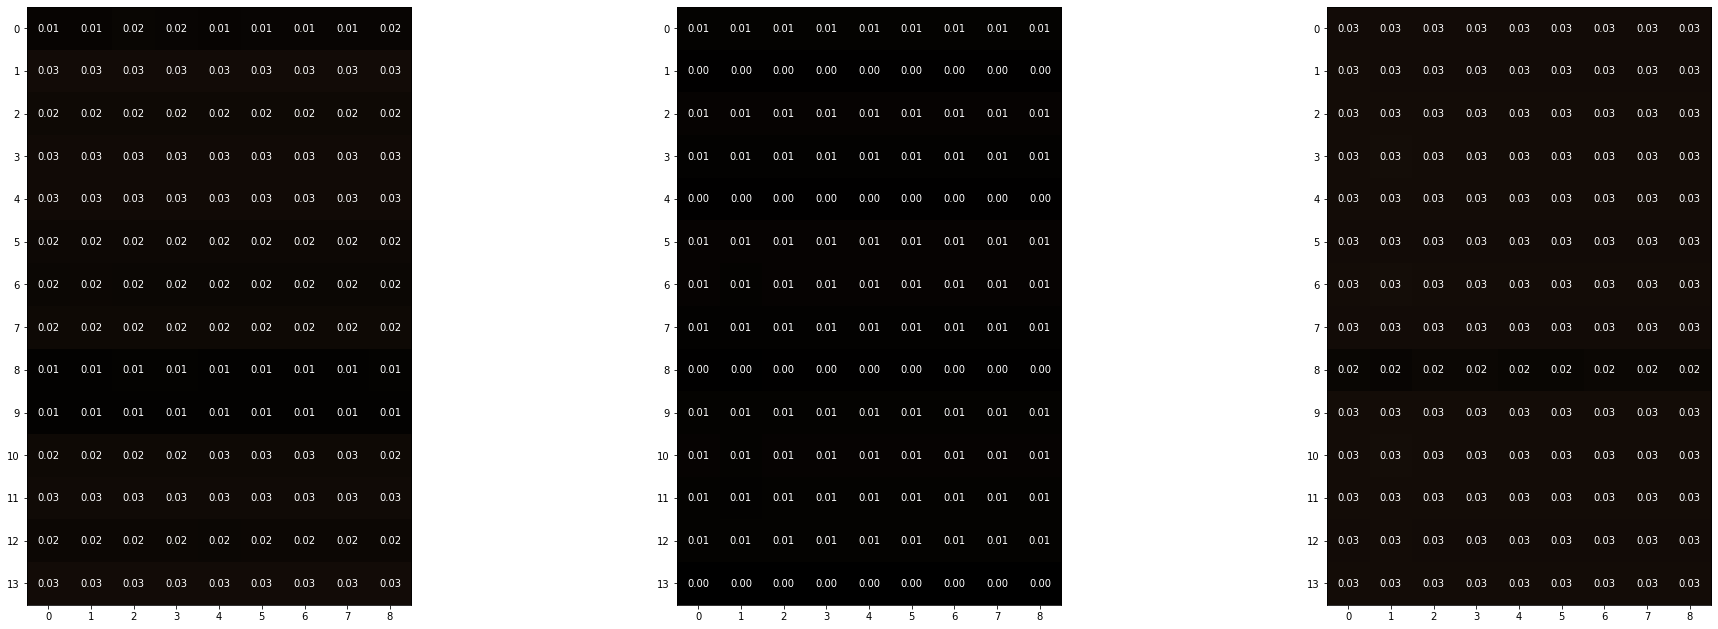

In [44]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    Uh_alive = US_alive[idx + 1]
    if (1 - Uh_alive).sum() < 1:
        print("{} No dead capsules for upper layer {}".format(idx ,idx + 1))
        continue
    
    
    C = C[:,np.where(Ul_alive == True)[0],:][:,:,np.where(Uh_alive == False)[0]]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

### Couplings FROM ALIVE TO ALIVE

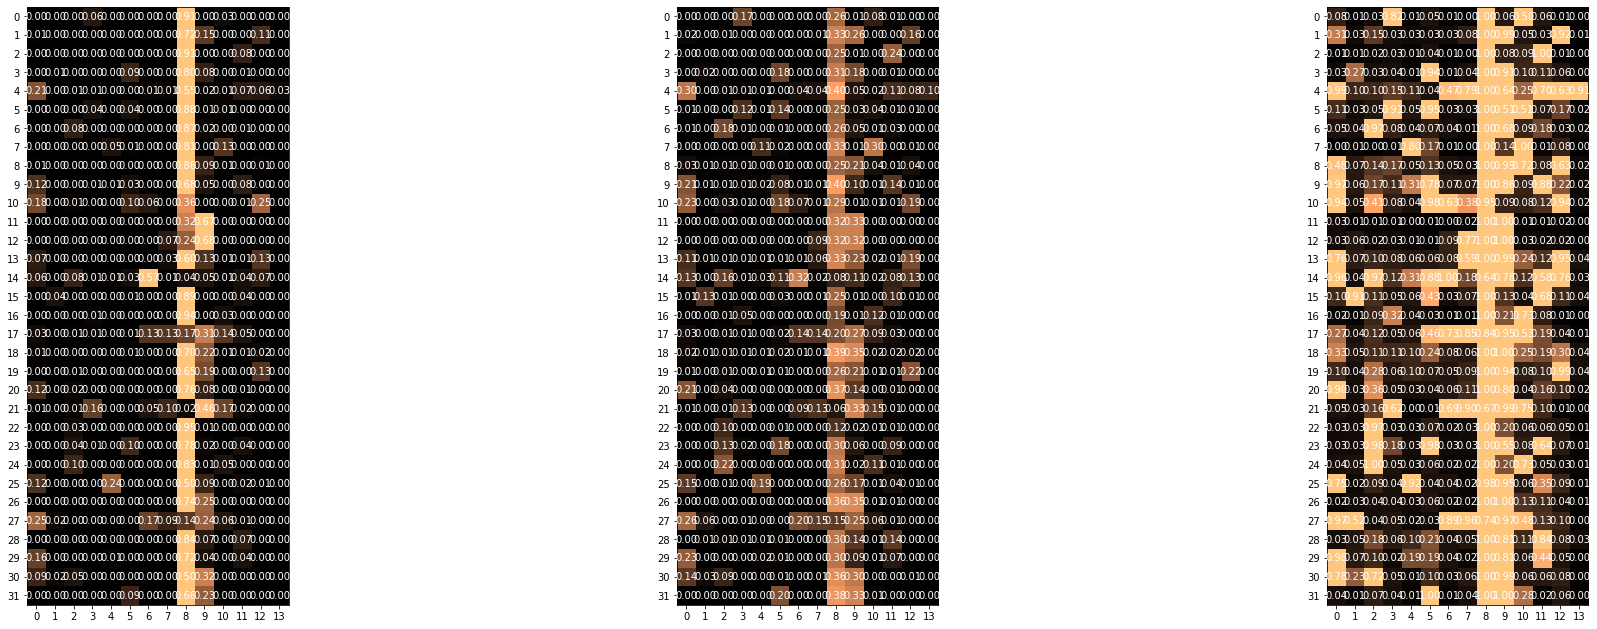

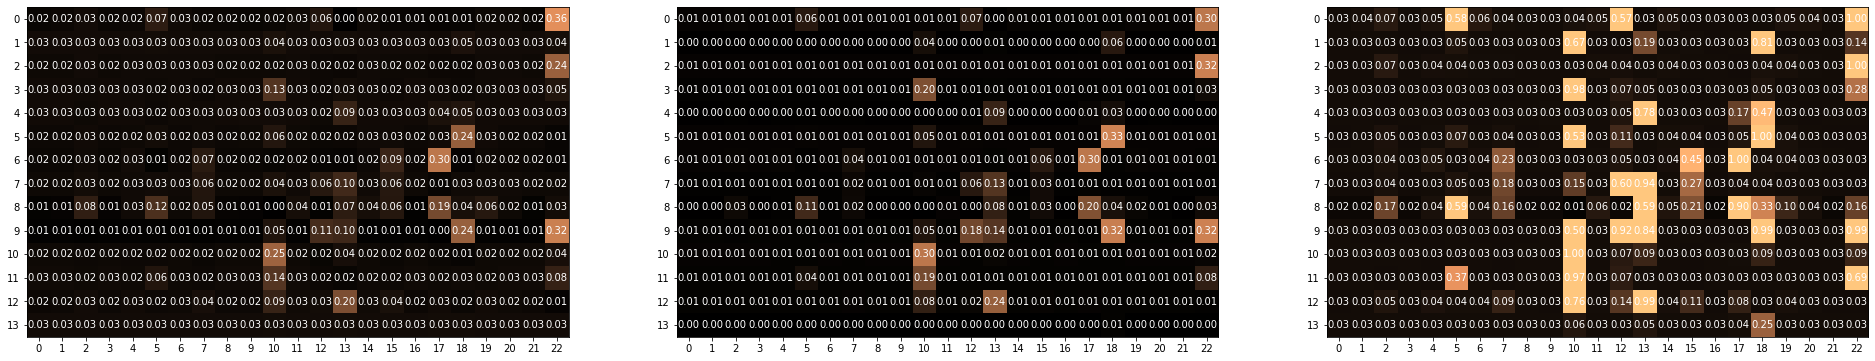

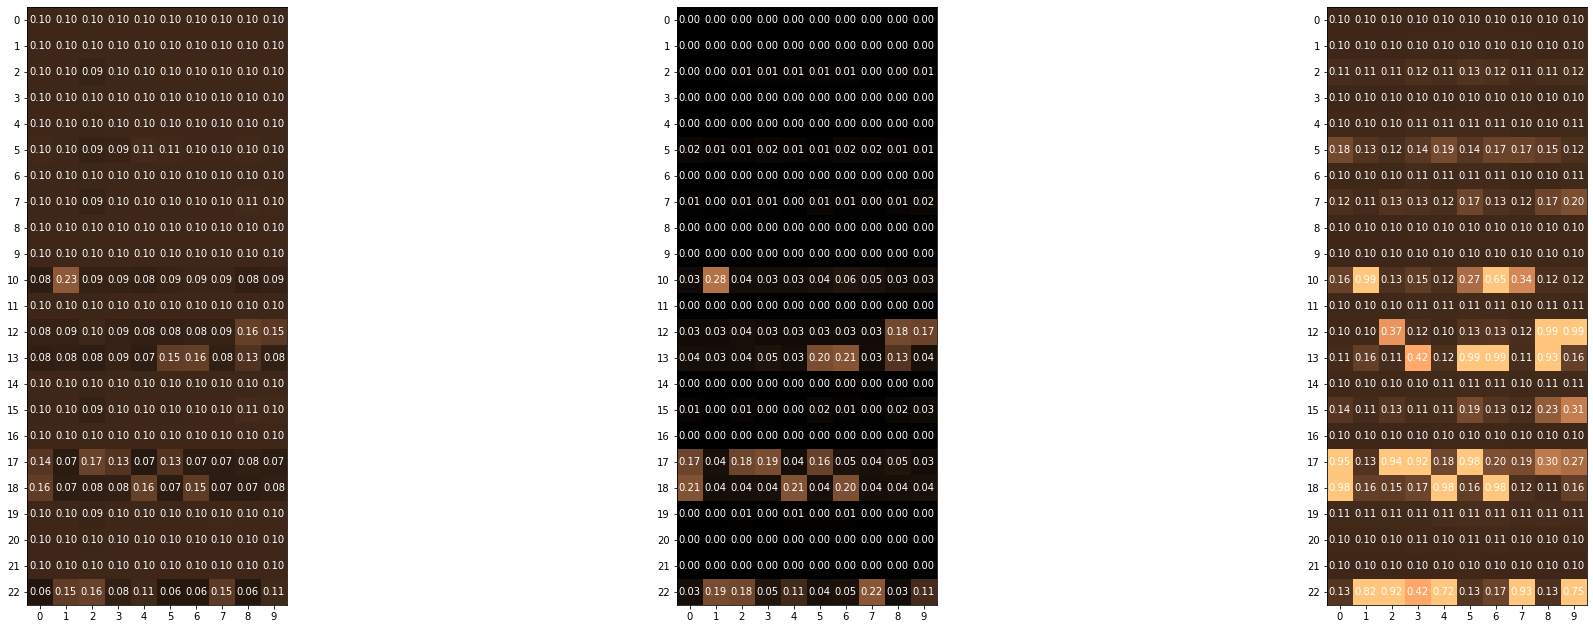

In [45]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    Uh_alive = US_alive[idx + 1]
    if (Uh_alive).sum() < 1:
        print("No dead capsules for upper layer {}".format(idx + 1))
        continue
    
    
    C = C[:,np.where(Ul_alive == True)[0],:][:,:,np.where(Uh_alive == True)[0]]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

# CNN Only Baseline

In [46]:
"""
epochs = 050, acc = 98,0, 73.0
epochs = 101, acc = 98.5, 74.1
epochs = 201, acc = 
"""

'\nepochs = 050, acc = 98,0, 73.0\nepochs = 101, acc = 98.5, 74.1\nepochs = 201, acc = \n'

In [47]:
model = CustomBB(ch_in=1, n_classes=10)
#
model = model.to(device)
#backbone
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=2e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)
#
criterion = nn.CrossEntropyLoss()

In [1]:
print(count_parameters(model))

NameError: name 'count_parameters' is not defined

In [ ]:
num_epochs = 101
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_mnist_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        logits = model.forward(x)
        loss = criterion(logits, y_true)

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(logits, dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    lr_scheduler.step()
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_mnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            logits = model.forward(x)
            
            y_pred = torch.argmax(logits, dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   mnist acc_valid: {:.3f}".format(total_correct / total))

    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_affnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            logits = model.forward(x)
            
            y_pred = torch.argmax(logits, dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   affnist acc_valid: {:.3f}".format(total_correct / total))